# 2. Exploratory Data Analysis + Prediction

**Objective:** Here, we aim to identify suitable prospects to refer back to a Relationship Manager’s portfolio. The data we have is socio-economic and geographic data provided by Manifold as well as our Foundation's data averaged at the postal code level for all of BC (2016). We aim to explore the following questions:

* What do postal codes that contribute the most donations to BCCH have in common?
* Regression: Do these socio-economic and demographic variables at the postal code level help predict *amount donated* by Postal Code?

**Approach:** We will run exploratory data analysis and then fit several classification/regression models


## I. EDA
***

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns 
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
import os
os.chdir('M:\\PH-RPM\\Elba\\Data\\')
data= pd.read_csv('MANIFOLD_BC_ALL.csv')
data.head()

,Unnamed: 0,Postal_Code,Population_Total,Pop_15_plus,Dwellings_Tot,ChildCount,Median_HH_Income,Health_Care_Spending,Financial_Services,Gifts_Money,...,Band housing-Count-PC_y,Tot_Priv_HH_Age_35-44,Tot_Priv_HH_Age_45-54,Tot_Priv_HH_Age_55-64,Tot_Priv_HH_Age_65-74,Tot_Priv_HH_Age_25-34,Tot_Priv_HH_Age_u_25,Tot_Priv_HH_Age_75_o,2017,2016
0,0,T9J1L8,34,28,11,6,262098,3656,1006,3582,...,0,2,3,1,1,4,0,0,0.0,50.0
1,1,V6M3B7,4,3,1,1,192482,2694,748,2136,...,0,0,0,0,0,0,0,0,NaN,NaN
2,2,V6M3B5,3,3,1,0,192061,2604,734,2078,...,0,0,0,0,0,0,0,0,NaN,NaN
3,3,V6M3G1,6,5,2,1,192342,2641,743,2107,...,0,0,0,0,1,0,0,0,NaN,NaN
4,4,V6M3B3,4,3,1,1,192061,2587,735,2072,...,0,0,0,0,0,0,0,0,NaN,NaN


In [3]:
# A bit more cleaning 
#First, we want to convert the nulls (postal codes that didn't donate in 2016/2017) to zeros
data['2016'].isnull().sum()
data['2016'] = data['2016'].fillna(0)
data['2017'] = data['2017'].fillna(0)

In [4]:
#data.head()

### Feature Engineering
**ChildPopRatio:** Here I generate a child proportion ratio in order to measure how many children there are in a particular postal code. This could be relevant regarding donations to the Children's Hospital.

In [5]:
data['ChildPopRatio'] = (( data['Population_Total'] - data['Pop_15_plus'])/data['Population_Total'])

I also want a variable that measures the proportion of individuals that are of a certain income level within a particular postal code.

In [6]:
Household_Income = ['HH_Inc_1','HH_Inc_2','HH_Inc_3','HH_Inc_4', 'HH_Inc_5','HH_Inc_6','HH_Inc_7','HH_Inc_8',\
                   'HH_Inc_9','HH_Inc_10','HH_Inc_11','HH_Inc_12','HH_Inc_13']
d = data['Dwellings_Tot'] 

for x in Household_Income: 
    data[x] = data[x]/d

I want to further aggregate the measure above into percentage of high, medium and low income percentage of individuals within a postal code. 

In [7]:
data['HH_Inc_Low'] =  data['HH_Inc_1'] + data['HH_Inc_2'] + data['HH_Inc_3'] + data['HH_Inc_4'] \
+ data['HH_Inc_5']  + data['HH_Inc_6'] 
data['HH_Inc_Med'] =  data['HH_Inc_7'] + data['HH_Inc_8'] + data['HH_Inc_9'] + data['HH_Inc_10'] 
data['HH_Inc_High'] = data['HH_Inc_11'] + data['HH_Inc_12'] + data['HH_Inc_13']

Finally, I extracted the following additional variables from our dataset: *Owned vs Rented dwelling* and *Age of Household Mantainer*. These variables can give us a good idea of an average Postal Code financial status and most importantly the average age of the houshold owner by postal code. I convert them to percentages to account for the differences in dwelling numbers per postal code. 

In [8]:
#Household ownership 
data['Owned_Dwelling_Percent'] = data['Owned-Count-PC']/data['Dwellings_Tot']
data['Rented_Dwelling_Percent'] = data['Rented-Count-PC']/data['Dwellings_Tot']
data['Band_Dwelling_Percent'] = data['Band housing-Count-PC_y']/data['Dwellings_Tot']
#Age of owners
data['Older_HH_Owners_Percent'] = (data['Tot_Priv_HH_Age_55-64'] + data['Tot_Priv_HH_Age_65-74'] + \
                                   data['Tot_Priv_HH_Age_75_o'])/data['Dwellings_Tot']
data['Younger_HH_Owners_Percent'] = (data['Tot_Priv_HH_Age_25-34'] + data['Tot_Priv_HH_Age_35-44'] + \
                                     data['Tot_Priv_HH_Age_u_25'] + data['Tot_Priv_HH_Age_45-54']  )/data['Dwellings_Tot']
data['Most_Senior_Owner_Percent'] = data['Tot_Priv_HH_Age_75_o']/data['Dwellings_Tot']

### How different variables relate to charitable contributions (all BC)

First, note that the variable 2016 is a sum of individual donations per postal code, while our other variables are mostly averages. For this analysis I will therefore create a new variable that reflects average BCCH donations for the year 2016:

In [9]:
data['2016_avg'] = data['2016']/data['Pop_15_plus']

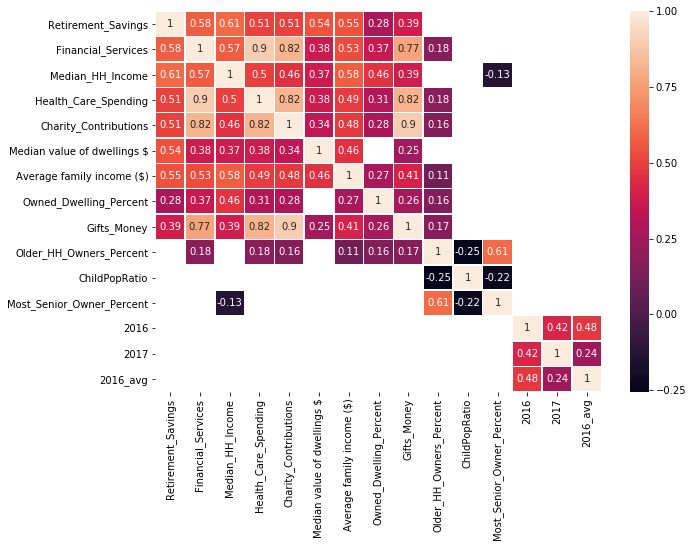

In [10]:
#Looking at correlation between variables
data =data[["Retirement_Savings" ,"Financial_Services", "Median_HH_Income","Health_Care_Spending",\
             "Charity_Contributions",'Median value of dwellings $', 'Average family income ($)', 'Owned_Dwelling_Percent',\
            'Gifts_Money', 'Older_HH_Owners_Percent',"ChildPopRatio",'Most_Senior_Owner_Percent', '2016', '2017', '2016_avg']] 

corr = data.corr()

mask = np.absolute(corr) > 0.10
fig, ax = plt.subplots(figsize=(10,7)) # Sample figsize in inches

sns.heatmap(corr[mask], 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True,  linewidths=.5,ax=ax)
plt.show()

Note that from the correlation matrix above, 2016 and 2017 are not correlated with any of our features- this means that the geographic data at the postal code level provided by Manifold might not be the best data to run predictions for donations to BCCH. 
 
Now we plot several variables to see their frequency distribution. Note the plot for BCCH 2016 contributions- the histogram seems oddly distributed. It'd be intersting to look at it further-since this will be our primary dependent variable.

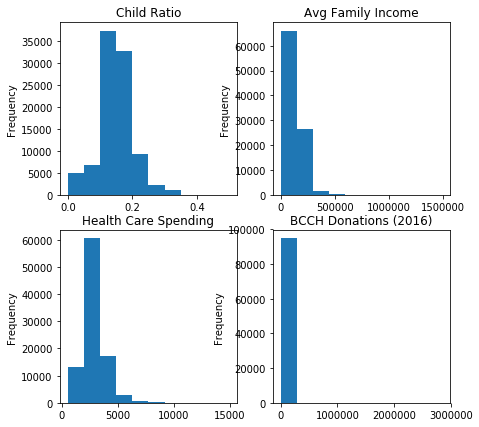

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(7, 7))
data['ChildPopRatio'].plot(ax=axes[0,0], kind='hist' ); axes[0,0].set_title('Child Ratio');
data['Average family income ($)'].plot(ax=axes[0,1],kind='hist'); axes[0,1].set_title('Avg Family Income');
data["Health_Care_Spending"].plot(ax=axes[1,0],kind='hist'); axes[1,0].set_title('Health Care Spending');
data["2016"].plot(ax=axes[1,1],kind='hist', bins=10); axes[1,1].set_title('BCCH Donations (2016)');

It seems like there are many postal codes that did not donate in 2016. Let's remove them from the analysis as well as the postal codes that have above 10,000 donations and focus on the distribution of postal codes that made a contribution in 2016. 

Text(0,0.5,'Frequency')

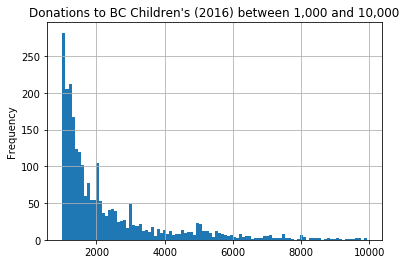

In [12]:
All_minus_high = data['2016'] < 10000
d1 = data[All_minus_high]
All_minus_low = d1['2016'] > 1000 
d1 = d1[All_minus_low]

d1.hist(column='2016', bins=100)
plt.title("Donations to BC Children's (2016) between 1,000 and 10,000")
plt.ylabel('Frequency')

In [13]:
#We take the top 10% of the donations ('Charitable Contributions')
data = data.sort_values("Charity_Contributions",ascending=False)
data_top = data.iloc[0:950]
data_top= data_top[["Charity_Contributions", 'Median_HH_Income', 'Health_Care_Spending',\
                    'Financial_Services', 'ChildPopRatio','Average family income ($)',\
                    'Median value of dwellings $', 'Owned_Dwelling_Percent','Older_HH_Owners_Percent',\
                    'Most_Senior_Owner_Percent', '2016', '2017', '2016_avg','Gifts_Money']]
#print (data_top.describe())
data_all= data[["Charity_Contributions", 'Median_HH_Income', 'Health_Care_Spending', \
                'Financial_Services', 'ChildPopRatio','Average family income ($)',\
                'Owned_Dwelling_Percent','Older_HH_Owners_Percent','Most_Senior_Owner_Percent',\
                 '2016', '2017','2016_avg','Gifts_Money']]
#print (data_all.describe())
#We take the top 10% of the donations ('BCCH 2016')
#data[['Charity_Contributions','ChildPopRatio']].head(1000)

In [14]:
data = data.sort_values("2016",ascending=False)
data_top_bcch = data.iloc[0:950]
data_top_bcch= data_top_bcch[["Charity_Contributions", 'Median_HH_Income', \
                              'Health_Care_Spending', 'Financial_Services', \
                              'ChildPopRatio','Average family income ($)',\
                              'Median value of dwellings $', 'Owned_Dwelling_Percent',\
                              'Gifts_Money','Older_HH_Owners_Percent','Most_Senior_Owner_Percent',\
                              '2016', '2017','2016_avg']]
#print (data_top_bcch.describe())

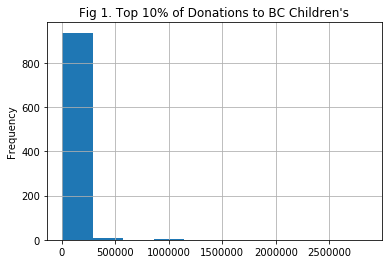

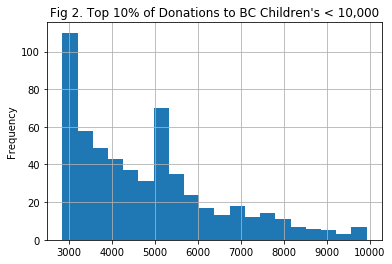

In [15]:
Top_minus_outliers = data_top_bcch['2016'] < 10000
data_top_trunc = data_top_bcch[Top_minus_outliers]

data_top_bcch.hist(column='2016', bins=10)
plt.title("Fig 1. Top 10% of Donations to BC Children's")
plt.ylabel('Frequency')
data_top_trunc.hist(column='2016', bins=20)
plt.title("Fig 2. Top 10% of Donations to BC Children's < 10,000")
plt.ylabel('Frequency')
plt.show()

* Note that if we focus on the top 10% of individuals donating to BC Children's in 2016, we still have an uninformative histogram. If we remove the 'outliers', namely constituents that donated **more** than 10,000 in a given year, we obtain figure 2. Here we can observe a consistent decline in frequency of donatiosns from 3,000 to 10,000 - where there are spikes both at 3,000 and 5,000. 

* The above analysis indicates that the donation thresholds vary significantly- thus, we may want to take a look at correlations at different donation thresholds. Below, we plot PC's with doantiosn between $1,000$ and $10,000$. It looks like our 2016_avg variable picks more correlations- but these are still fairly weak.

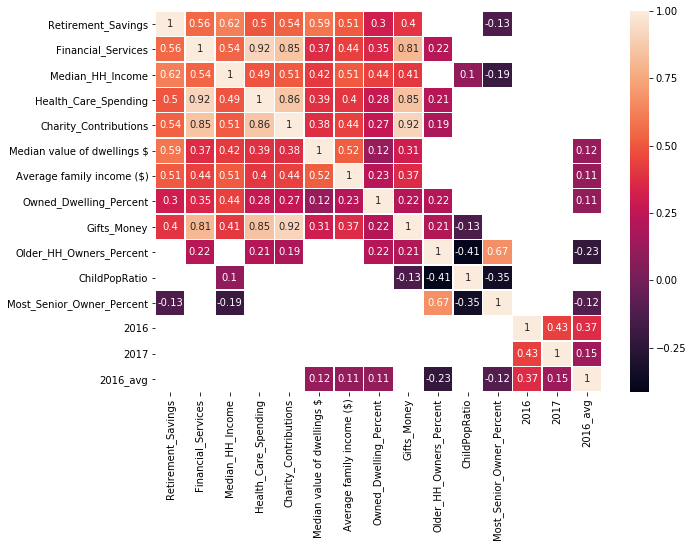

In [16]:
corr = d1.corr()

mask = np.absolute(corr) > 0.1
fig, ax = plt.subplots(figsize=(10,7)) # Sample figsize in inches

sns.heatmap(corr[mask], 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True,  linewidths=.5,ax=ax)
plt.show()

## How do the most charitable postal code look like? Top 10% in BC
Here, we selected the top 10% of postal codes that spend the most in lieu of charitable contributions per year that donated less than 10,000. We can observe that by all measures, these individuals don't stray too far away from the BC average in terms of age, income, and health care spending.

| Variable  | Top 10% Mean_CC | Top 10% SD CC |All PC Mean |All PC SD | Top 10% Mean_BCCH <10000 |Top 10% SD_BCCH <10000 |
|----------|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
| Average Charitable Contribution  | 4,463 | 1,131|991|500 |1079|709|
| Median_HH_Income  |148,736 | 49,549|76,853|29,233 |80,718|35,513|
| Health_Care_Spending |     7,222  | 1,485 |2,903|1002 |3,112|1,237|
| Financial_Services    |   1,937  |404|712|272|778|341|
| Percentage of Children   |   12% |6% |14%|5%|14%|4%|
|Average family income ($) |   400,000  |216,000 |137,000|82,500|164,500|144,300|
|Owned_Dwelling_Percent |   90%  |11% |76%|21%|76%|20%|
|Old_Household_Owners |  56%  |28% |40%|20%|44%|21%|
|Most_Senior_Owner |  15%  |16% |9%|13%|10%|12%|
|Younger_HH_Owners_Percent  | 32%  |22% |52%|24%|51%|22%|
|2016 Donations to BC Childrens  |1,860  |9,720 |798|18,800|4,796|1,659|
|2017 Donations to BC Childrens  |1,133 |6,009 |400|7,139|2,820|3,082|

## II. Prediction 
***

### Regression Problem 

We compare our models using the $R^2$ and $RMSE$ statistics.

* $R^2$: proportion of the variance in the dependent variable that is predictable from the independent variable(s). Recall the definition of the unadjusted $R^2$:

\begin{equation}
R^2 = 1 - \dfrac{ \dfrac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^{2}}{\dfrac{1}{n}\sum_{i=1}^{n}(y_i - \bar{y})^{2}}
\end{equation}


* $RMSE$:Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). 
\begin{equation}
\sqrt{\dfrac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i})^{2}}
\end{equation}


### `Multivariate Regression`

In [17]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#First, we want to convert the nulls (postal codes that didn't donate in 2016/2017) to zeros
data['2016'].isnull().sum()
data['2016'] = data['2016'].fillna(0)
data['2017'] = data['2017'].fillna(0)

#### Testing benchmark and alternative models with BCCH donations in 2016 as the outcome variable 
X1 = d1[['Median_HH_Income','Health_Care_Spending', 'Financial_Services','Gifts_Money', \
          'Charity_Contributions','Retirement_Savings' ]] 

X2 = d1[['Charity_Contributions','Average family income ($)', \
          "Retirement_Savings" ,"Financial_Services","Health_Care_Spending",\
          'Owned_Dwelling_Percent','Older_HH_Owners_Percent', 'Gifts_Money']] 

list = [X1, X2]

for X in list:
    # Create training and test sets
    
    y = d1['2016_avg']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    # Create the regressor: reg_all
    reg_all = LinearRegression()

   # Fit the regressor to the training data
    reg_all.fit(X_train, y_train)

    # Predict on the test data: y_pred
    y_pred = reg_all.predict(X_test)

    # Compute and print R^2 and RMSE
    print("R^2: {}".format(reg_all.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error: {}".format(rmse))


R^2: 0.02021616607395904
Root Mean Squared Error: 195.82352295951821
R^2: 0.05643177640568986
Root Mean Squared Error: 192.17034867293594


In [18]:
print(len(X1) == len(X2))
print(len(y) == len(X2))
print(len(X2))

True
True
2437


In [19]:
#### Testing benchmark and alternative models with Charity Contributions in 2017 as the outcome variable 
M1 = d1[['Median_HH_Income','Health_Care_Spending', 'Financial_Services','Gifts_Money', \
          'Retirement_Savings', '2016']] 

M2 = d1[['Average family income ($)', "ChildPopRatio", \
          "Retirement_Savings" ,"Financial_Services","Health_Care_Spending",\
          'Owned_Dwelling_Percent','Older_HH_Owners_Percent','2016','Gifts_Money']] 

list = [M1, M2]

for X in list:
    # Create training and test sets
    y = d1['Charity_Contributions']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    # Create the regressor: reg_all
    reg_all = LinearRegression()

   # Fit the regressor to the training data
    reg_all.fit(X_train, y_train)

    # Predict on the test data: y_pred
    y_pred = reg_all.predict(X_test)

    # Compute and print R^2 and RMSE
    print("R^2: {}".format(reg_all.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.895660488789674
Root Mean Squared Error: 196.04541681869625
R^2: 0.8977817950945128
Root Mean Squared Error: 194.04230269087867


### `Multivariate Regression with PCA Regressors`
Now, let's try PCA for regessor dimension reduction

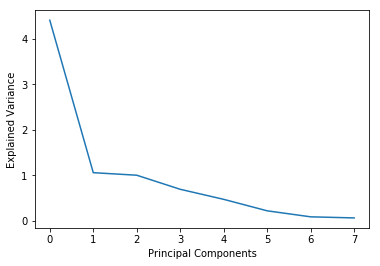

In [20]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import scale
# run an initial PCA to find the number of components to run with
pca = PCA()

X2 = d1[['Charity_Contributions','Average family income ($)', \
          "Retirement_Savings" ,"Financial_Services","Health_Care_Spending",\
          'Owned_Dwelling_Percent','Older_HH_Owners_Percent', 'Gifts_Money']] 

#fit the model to our X2 data and standardize 
pca_features = pca.fit_transform(scale(X2))

m = pca.components_

# looks like we want to two one PC.
plt.plot(pca.explained_variance_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')

plt.show()

In [21]:
print(len(X2))

2437


In [22]:
pca = PCA(n_components=2)

#drop year and aggregate by neighbourhood. Here we want a spatial pca.
pca_features = pca.fit(scale(X2))

m = pca.components_

pcs = pd.DataFrame(pca.transform(scale(X2)))

geographical_srq_pcs = pd.concat((X2,pcs), axis=1)

# merge the loadings together. This allows for direct interpretation of the loadings later.
all_loadings = -1 * pca.components_.T * np.sqrt(pca.explained_variance_)

# transpose and convert to a DF. The columns will be the variables, rows will be PCs. Each cell gives loading of a given variable into a given PC 
all_loadings = pd.DataFrame(all_loadings.T, columns=X2.columns.values)

#all_loadings

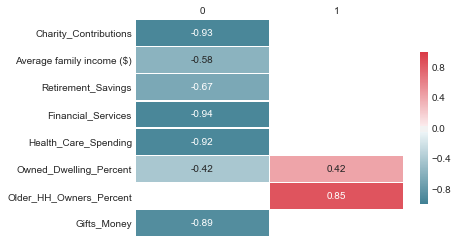

In [23]:
#we set style for a nicer matrix 
sns.set_style("whitegrid")

# create our colour map.
cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.absolute(all_loadings) > 0.3

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(all_loadings[mask].T, cmap=cmap, center=0, vmax = 1, vmin = -1, annot=True,
             linewidths=.5, cbar_kws={"shrink": .7}, )

ax.xaxis.set_ticks_position('top')

plt.show()

### `Random Forest`

In [25]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
import pandas as pd 
import time

rng= 1 

X1 = d1[['Median_HH_Income','Health_Care_Spending', 'Financial_Services','Gifts_Money', \
          'Charity_Contributions','Retirement_Savings']] 
y = d1['2016_avg']  

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=rng)

# Instantiate rf
rf = RandomForestRegressor(n_estimators=500,
            random_state=rng)
            #with 100 the RMSE was 9966.14 now with 500 the RMSE is 7856.39
# Fit rf to the training set    
rf.fit(X_train, y_train) 

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of Random Forest: {:.2f}'.format(rmse_test))

Test set RMSE of Random Forest: 275.74


In [26]:
# Import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
import pandas as pd 

y= d1['Charity_Contributions']

X2_R = d1[['Average family income ($)', \
          "Retirement_Savings" ,"Financial_Services","Health_Care_Spending",\
          'Owned_Dwelling_Percent','Older_HH_Owners_Percent','Gifts_Money']] 

# Set SEED for reproducibility
SEED = 1

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X2_R, y, test_size=0.3, random_state=rng)

# Instantiate rf
rf = RandomForestRegressor(n_estimators=500, #RMSE was 199.88 with 25 trees; with 500 trees it's 198.84
            random_state=SEED)
            
# Fit rf to the training set    
rf.fit(X_train, y_train) 

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of Random Forest: {:.2f}'.format(rmse_test))

Test set RMSE of Random Forest: 152.25


### `Gradient Boosting`

In [29]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE

#Loop so that we can scale to different regressors later
list = [X1]

for X in list:
    
    # Instantiate gb
    gb = GradientBoostingRegressor(max_depth=4, 
            n_estimators=500,
            random_state=rng)

    #y= data['2016']
    y = d1['2016_avg']  
    # Split the data into 70% train and 30% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

    # Fit gb to the training set
    gb.fit(X_train, y_train)

    # Predict test set labels
    y_pred = gb.predict(X_test)

    # Compute MSE
    mse_test = MSE(y_test, y_pred)

    # Compute RMSE
    rmse_test = mse_test**(1/2)

    # Print RMSE
    print('Test set RMSE of gb: {:.3f}'.format(rmse_test))

Test set RMSE of gb: 291.752


In [30]:
# Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE

list = [X2_R]

for X in list:
    
    # Instantiate gb
    gb = GradientBoostingRegressor(max_depth=4, 
            n_estimators=500,
            random_state=rng)

    y= d1['Charity_Contributions']
    # Split the data into 70% train and 30% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rng)

    # Fit gb to the training set
    gb.fit(X_train, y_train)

    # Predict test set labels
    y_pred = gb.predict(X_test)

    # Compute MSE
    mse_test = MSE(y_test, y_pred)

    # Compute RMSE
    rmse_test = mse_test**(1/2)

    # Print RMSE
    print('Test set RMSE of gb: {:.3f}'.format(rmse_test))


Test set RMSE of gb: 157.543


### Model Results:

#### Internal: BCCH Donations Predictions

Now that we have a better understanding of our dataset, we can go ahead and perform some predictive analysis for our response variable: **2016 donations to BCCH**. Note that $\overline{y} = \$93$. 
* `Multivariate Regression`

    * Here, we run a benchmark model with the 4 variables with which we started the analysis and an alternative model that includes all the additional features we have extracted and engineered. The resulting RMSE and $R^2$ are $-0.003$ and $172.638$ for our benchmark and $-0.003$ and $172.658$ for our alternative model. Since the MSE and $R^2$ don't change too much, the additional variables don't add too much predictive power.

* `Multivarate Regression with PCA regressors`

    * Here, we attempt to improve the predictive capacity by reducing all our information in the second model into two PC loadings (also deal with multicollinearity since many regressors are highly correlated with each other) which we then use as regressors. Resulting RMSE and $R^2$ are $0.011$ and $171.343$ so although an improvement the model is still bad. 

* `Random Forest`

    * For Random Forest, the result is much worse. We get a RMSE of $555$ with 500 trees.

* `Boosting` 

    * Finally, with boosting our results are even worse than RF with a RMSE of $480$

#### External: Manifold 'Charitable Contributions' Predictions

As a comparison, the results on 'Charitable Contributions' as the outcome variable are much more promising. Just to give some examples, the RMSE with linear regression is $206$ and the smallest RMSE is $130$, achieved with Random Forest regression we also get an $R^2$ of around $0.85$. Note that the average charitable contributions per postal code are $\overline{y} = \$1027$. 

Some comments:
* It looks like the prediction is much improved by only including 2017 but not the inverse (predicting 2017 based on 2016). I wonder what it's tapping into? Well by construction you only get 2017 if you have 2016
* Also note that we can't really accurately predict 2017 because it's only non-zero if the individual also donated in the past year

## III. Conclusion
***
From what we've observed above, it looks like the geographic data we have from Manifold does not help to significantly predict the internal BCCH data (specifically overall hospital donations). This means that although valuable, the Manifold data should be used for the purposes of visualziation and general understanding, rather than for prediction and analysis stategies. 